# Optimizer Visualizer for Gradient Descent

**Math of Machine Learning**

This notebook provides an interactive exploration of how different optimization algorithms navigate loss surfaces during gradient descent.

## Learning Objectives
1. Understand how different optimizers behave on various loss landscapes
2. Visualize the effect of convexity on convergence
3. Explore how local minima trap different optimizers
4. Compare adaptive vs. non-adaptive methods


In [27]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Set up matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Import our modules
from loss_surfaces import (
    QuadraticBowl, EllipticalBowl, Rosenbrock, Rastrigin,
    Ackley, Beale, SaddlePoint, SixHumpCamel,
    get_loss_surfaces_by_category
)
from optimizers import (
    SGD, Momentum, NesterovMomentum, AdaGrad, RMSprop, Adam,
    run_optimization, get_all_optimizers
)
from datasets import (
    generate_linear_separable, generate_moons, generate_circles,
    generate_xor, generate_spiral, LogisticRegressionLoss, PCAProjector
)
from visualizer import (
    SurfaceVisualizer, create_comparison_figure,
    create_optimizer_summary_table, plot_surface_comparison
)

print("✓ All modules loaded successfully!")


✓ All modules loaded successfully!


---
## Part 1: Loss Surface Overview

Let's first visualize the different types of loss surfaces we'll be working with.


In [28]:
# Get surfaces organized by category
surfaces_by_category = get_loss_surfaces_by_category()

print("Loss Surfaces by Category:")
print("="*50)
for category, surfaces in surfaces_by_category.items():
    print(f"\n{category.upper()}:")
    for s in surfaces:
        print(f"  • {s.name}: {s.description}")


Loss Surfaces by Category:

CONVEX:
  • Quadratic Bowl: Convex quadratic: 1.0x² + 1.0y² (condition number: 1.0)
  • Quadratic Bowl: Convex quadratic: 1.0x² + 10.0y² (condition number: 10.0)
  • Elliptical Bowl: Rotated ellipse with eccentricity 10.0

MULTI_LOCAL_MIN:
  • Rastrigin: Multi-modal with regular local minima grid
  • Ackley: Deep central minimum with flat outer regions
  • Six-Hump Camel: Six local minima, two global minima

NON_CONVEX:
  • Rosenbrock: Banana-shaped valley - easy to find, hard to converge
  • Beale: Flat regions with sharp valleys
  • Saddle Point: x² - y² with saddle at origin


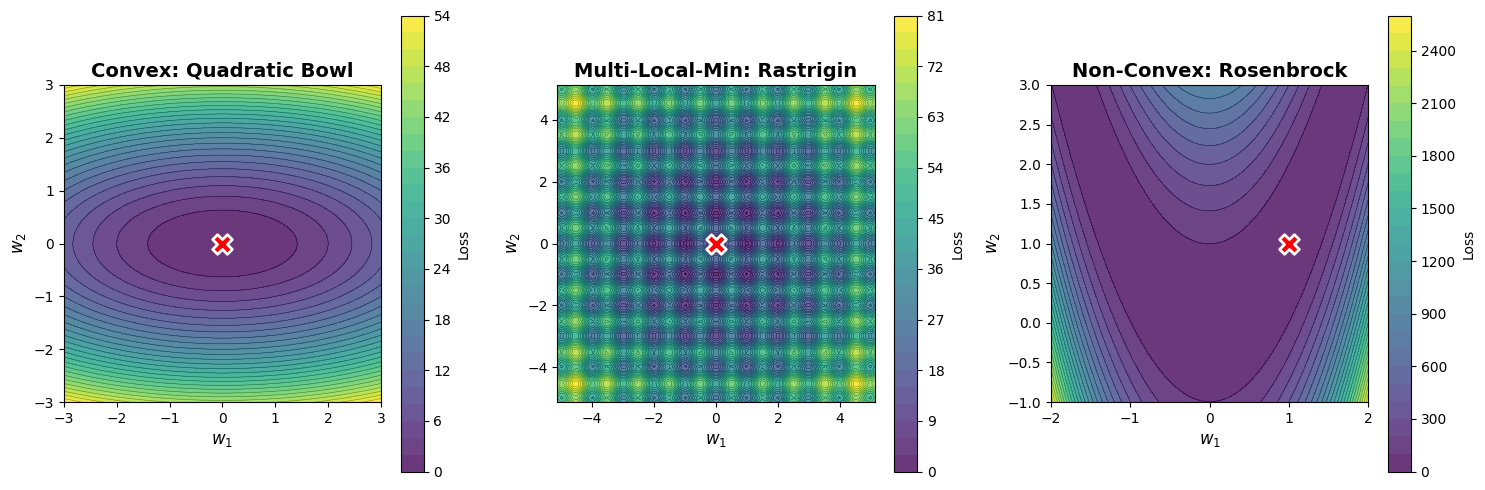

In [29]:
# Visualize one surface from each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

demo_surfaces = [
    (QuadraticBowl(a=1, b=5), "Convex"),
    (Rastrigin(), "Multi-Local-Min"),
    (Rosenbrock(), "Non-Convex")
]

for ax, (surface, category) in zip(axes, demo_surfaces):
    viz = SurfaceVisualizer(surface, resolution=80)
    viz.plot_contour(ax=ax, title=f"{category}: {surface.name}")

plt.tight_layout()
plt.show()


---
## Part 2: Convex Optimization

On convex surfaces, all optimizers will converge to the global minimum. The question is: **how fast?**

### 2.1 Well-Conditioned Quadratic


Surface: Convex quadratic: 1.0x² + 1.0y² (condition number: 1.0)
Starting point: [4. 4.]
Optimal point: [0. 0.]


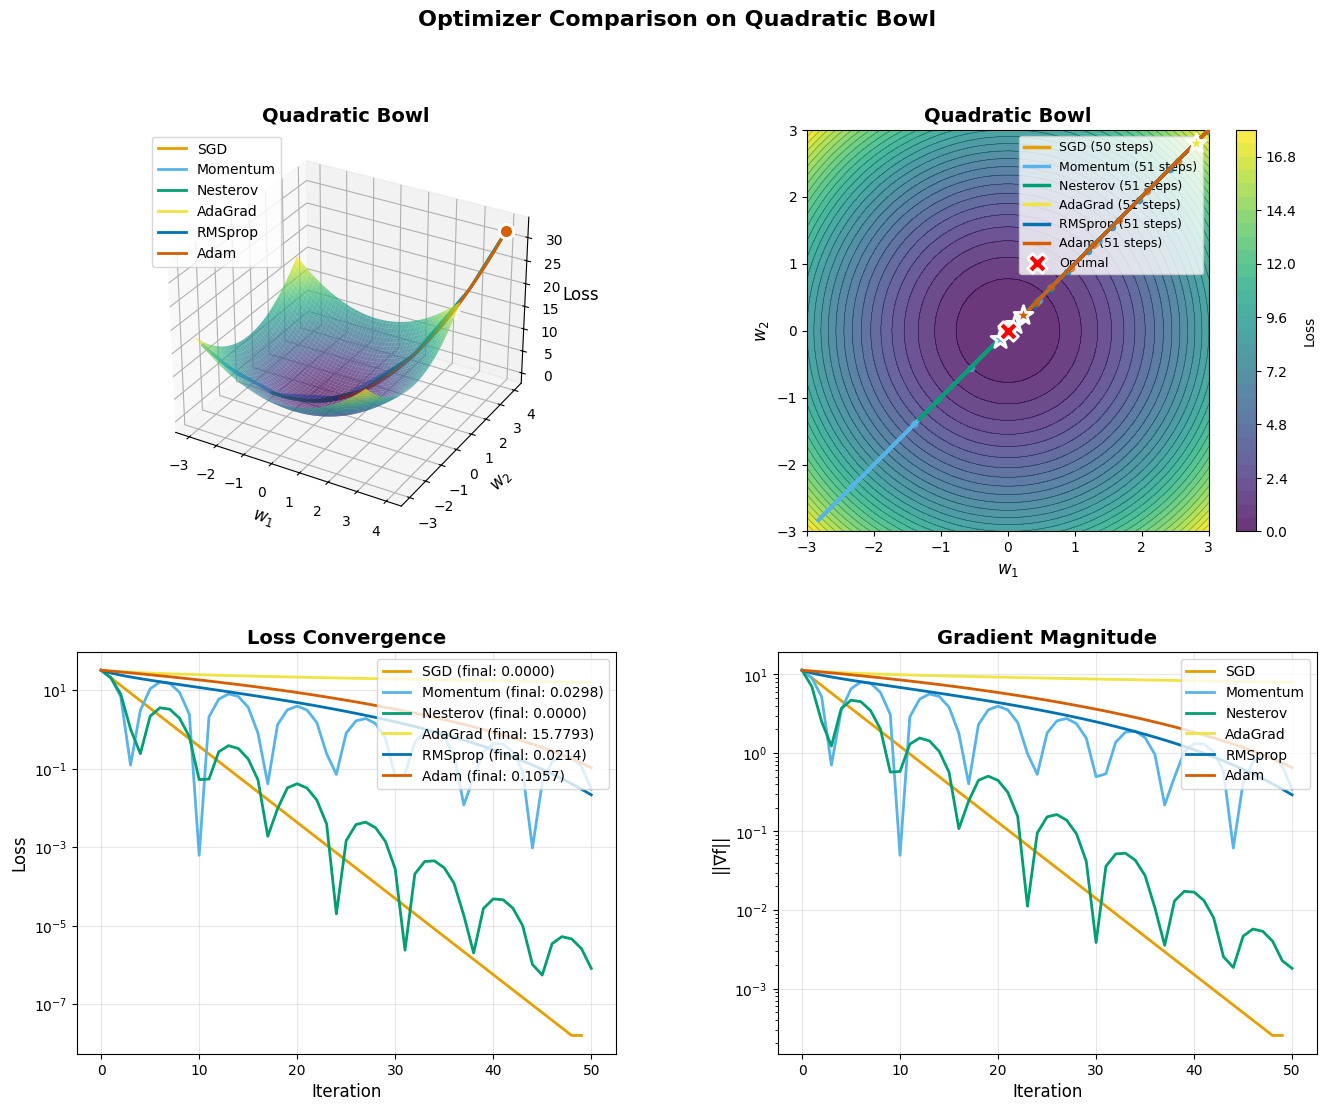


Optimizer       Steps    Final Loss   Final Position           
---------------------------------------------------------------
SGD             50       0.000000     [0.0001, 0.0001]         
Momentum        51       0.029765     [-0.1220, -0.1220]       
Nesterov        51       0.000001     [-0.0006, -0.0006]       
AdaGrad         51       15.779315    [2.8089, 2.8089]         
RMSprop         51       0.021434     [0.1035, 0.1035]         
Adam            51       0.105744     [0.2299, 0.2299]         


In [30]:
# Well-conditioned quadratic (condition number = 1)
surface = QuadraticBowl(a=1.0, b=1.0)
initial = np.array([4.0, 4.0])

print(f"Surface: {surface.description}")
print(f"Starting point: {initial}")
print(f"Optimal point: {surface.get_optimal()}")

# Run all optimizers
trajectories = []
for opt in get_all_optimizers(learning_rate=0.1):
    history = run_optimization(surface, opt, initial, num_steps=50)
    trajectories.append(history)

# Visualize
fig = create_comparison_figure(surface, trajectories)
plt.show()

# Summary
print("\n" + create_optimizer_summary_table(trajectories))


### 2.2 Ill-Conditioned Quadratic

When the condition number is high, some dimensions have much larger curvature than others. This creates challenges for non-adaptive methods.


Surface: Convex quadratic: 1.0x² + 10.0y² (condition number: 10.0)
Note: The y-direction has 10x higher curvature than x.


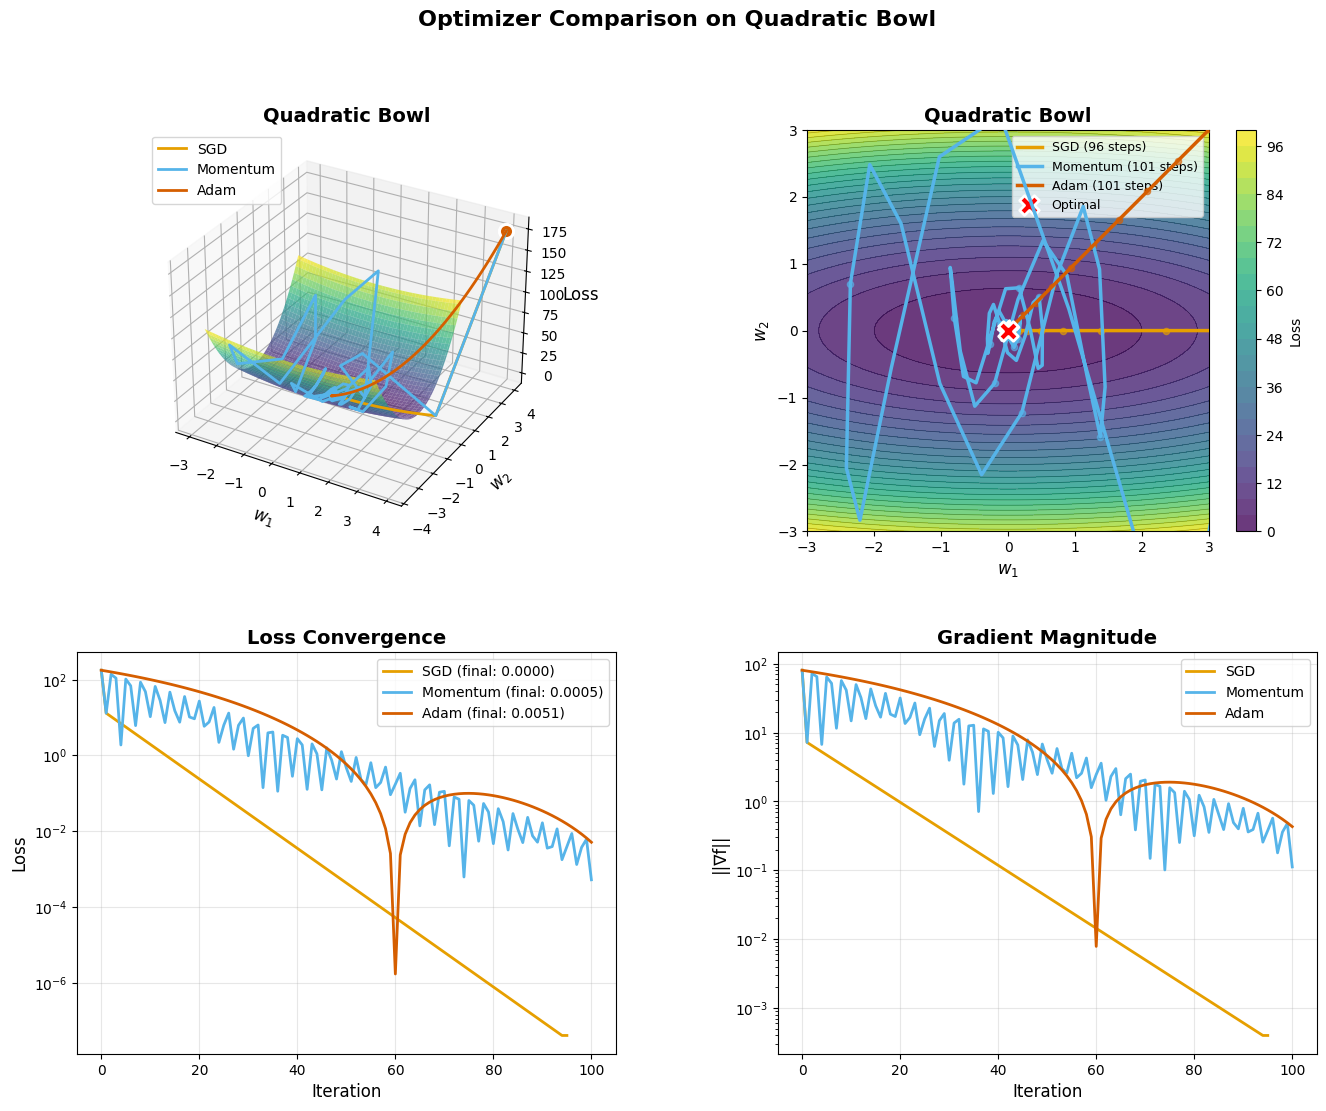


Optimizer       Steps    Final Loss   Final Position           
---------------------------------------------------------------
SGD             96       0.000000     [0.0002, 0.0000]         
Momentum        101      0.000515     [0.0150, 0.0054]         
Adam            101      0.005052     [-0.0214, -0.0214]       


In [31]:
# Ill-conditioned quadratic (condition number = 10)
surface = QuadraticBowl(a=1.0, b=10.0)
initial = np.array([4.0, 4.0])

print(f"Surface: {surface.description}")
print("Note: The y-direction has 10x higher curvature than x.")

# Compare SGD vs Adam
optimizers = [
    SGD(learning_rate=0.05),
    Momentum(learning_rate=0.05, beta=0.9),
    Adam(learning_rate=0.1),
]

trajectories = []
for opt in optimizers:
    history = run_optimization(surface, opt, initial, num_steps=100)
    trajectories.append(history)

fig = create_comparison_figure(surface, trajectories)
plt.show()

print("\n" + create_optimizer_summary_table(trajectories))


**Question:** Why does SGD oscillate while Adam converges smoothly?

---
## Part 3: Local Minima and Non-Convexity

### 3.1 Rastrigin Function (Many Local Minima)


Surface: Rastrigin
Global minimum at: [0. 0.]

This surface has local minima at every integer coordinate!


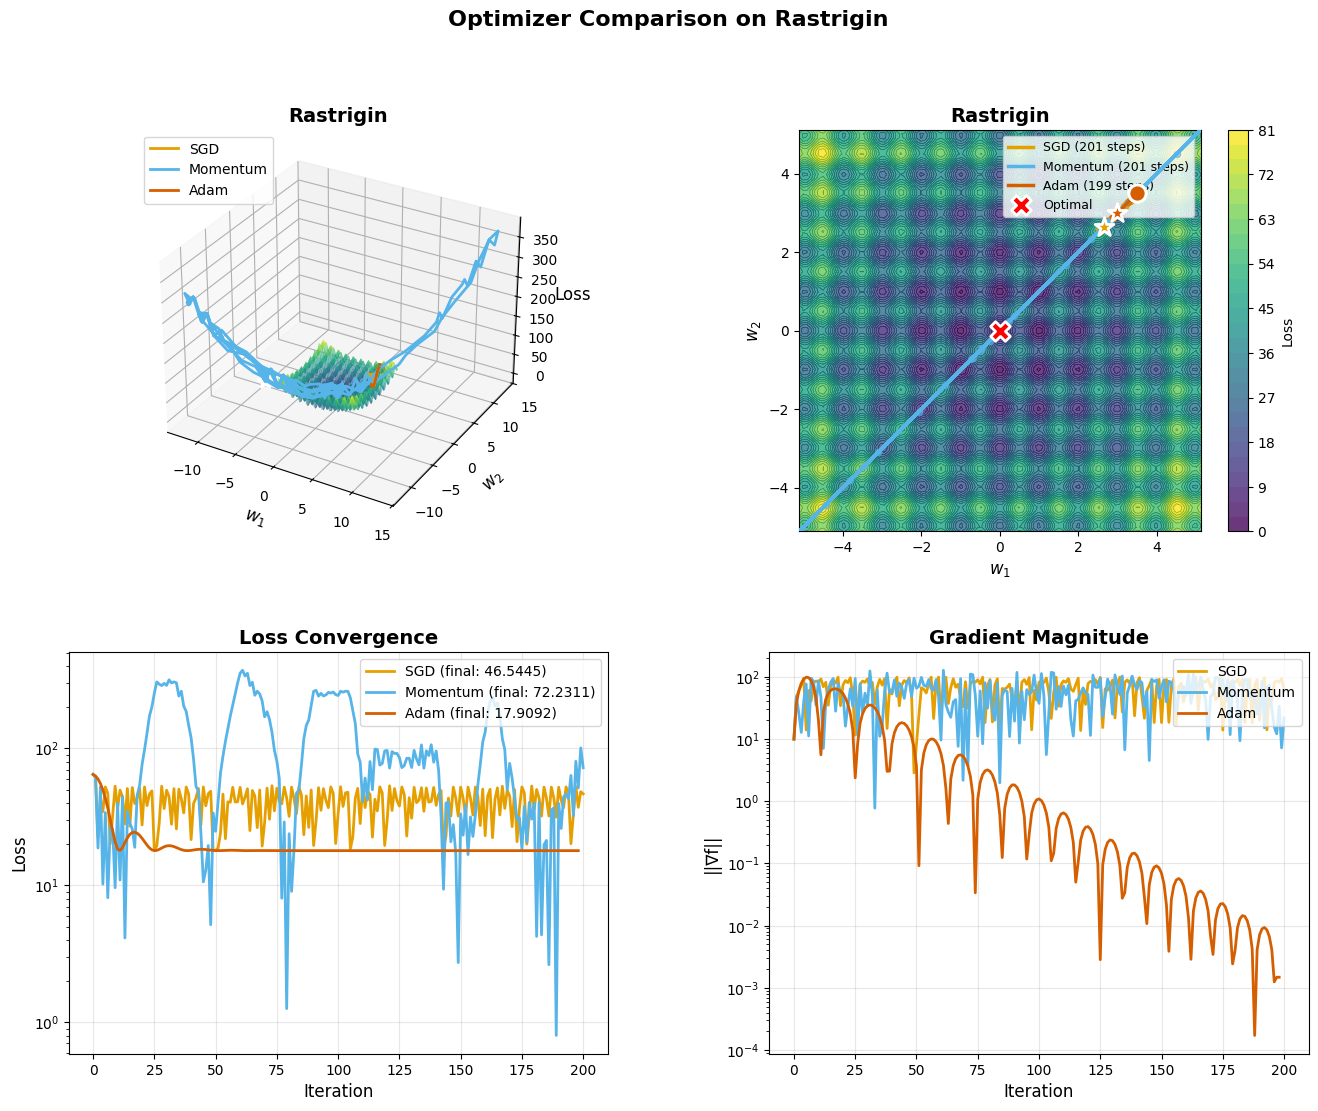


Optimizer       Steps    Final Loss   Final Position           
---------------------------------------------------------------
SGD             201      46.544512    [2.6417, 2.6417]         
Momentum        201      72.231119    [-6.0084, -6.0084]       
Adam            199      17.909202    [2.9849, 2.9849]         


In [32]:
# Rastrigin function - highly multimodal
surface = Rastrigin(A=10.0)
initial = np.array([3.5, 3.5])

print(f"Surface: {surface.name}")
print(f"Global minimum at: {surface.get_optimal()}")
print("\nThis surface has local minima at every integer coordinate!")

# Try different optimizers
optimizers = [
    SGD(learning_rate=0.01),
    Momentum(learning_rate=0.01, beta=0.9),
    Adam(learning_rate=0.05),
]

trajectories = []
for opt in optimizers:
    history = run_optimization(surface, opt, initial, num_steps=200)
    trajectories.append(history)

fig = create_comparison_figure(surface, trajectories)
plt.show()

print("\n" + create_optimizer_summary_table(trajectories))


### 3.2 Rosenbrock Function (Narrow Valley)


Surface: Rosenbrock
Global minimum at: [1. 1.]

The challenge: finding the valley is easy, converging is hard.


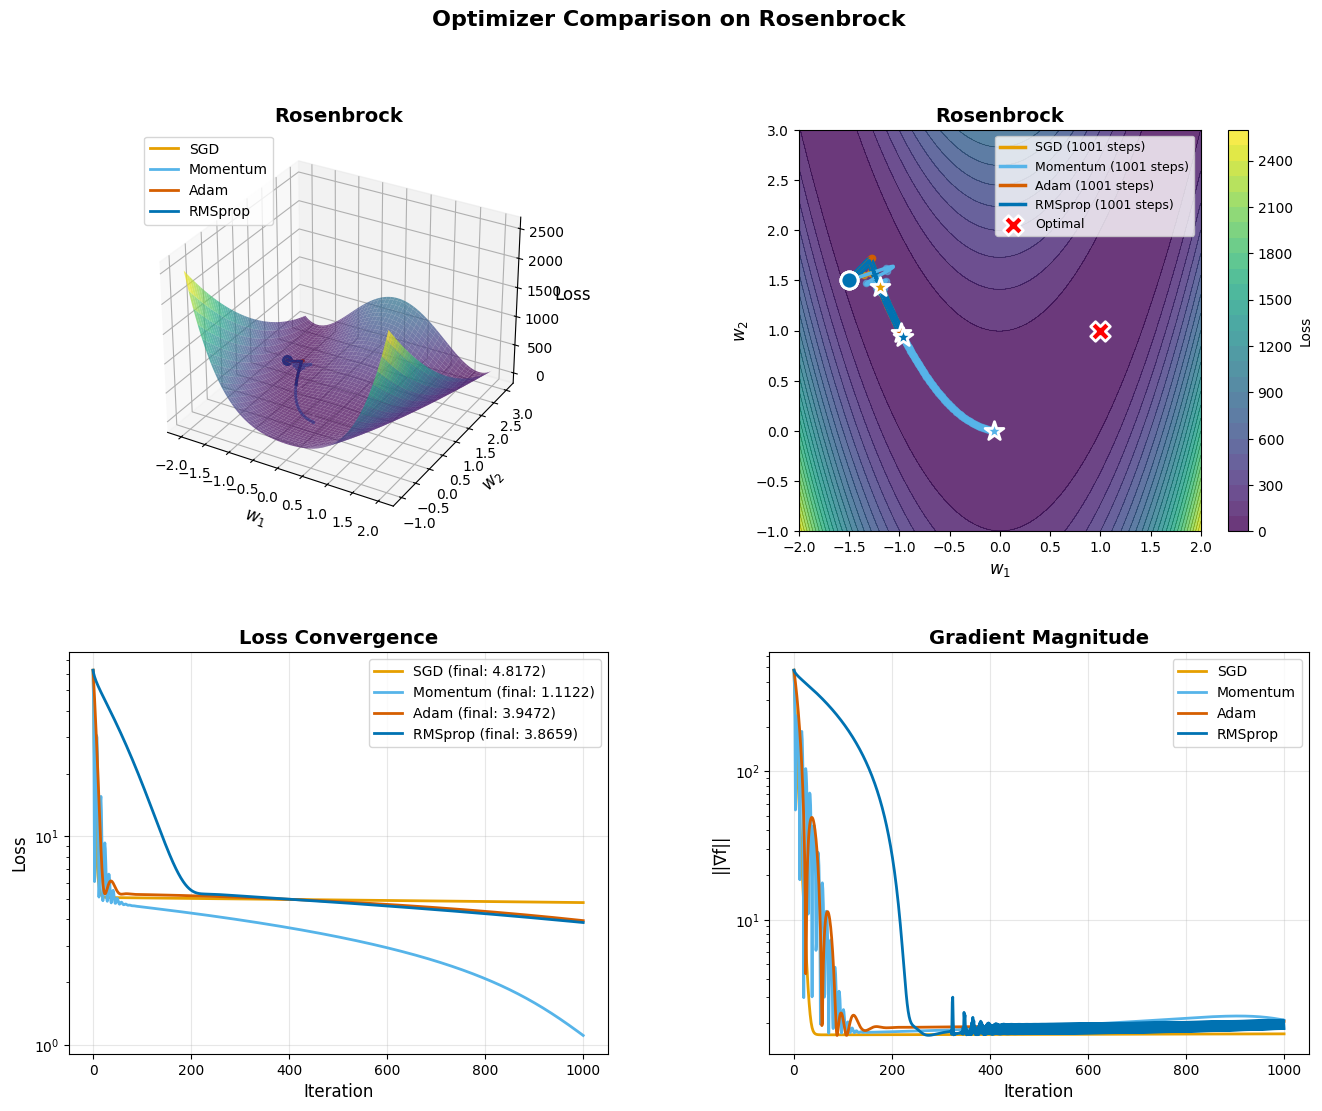


Optimizer       Steps    Final Loss   Final Position           
---------------------------------------------------------------
SGD             1001     4.817227     [-1.1934, 1.4321]        
Momentum        1001     1.112242     [-0.0546, 0.0039]        
Adam            1001     3.947162     [-0.9859, 0.9778]        
RMSprop         1001     3.865850     [-0.9642, 0.9385]        


In [33]:
# Rosenbrock - the classic banana function
surface = Rosenbrock(a=1.0, b=100.0)
initial = np.array([-1.5, 1.5])

print(f"Surface: {surface.name}")
print(f"Global minimum at: {surface.get_optimal()}")
print("\nThe challenge: finding the valley is easy, converging is hard.")

# Need small learning rates for SGD on Rosenbrock
optimizers = [
    SGD(learning_rate=0.0001),
    Momentum(learning_rate=0.0001, beta=0.9),
    Adam(learning_rate=0.01),
    RMSprop(learning_rate=0.001),
]

trajectories = []
for opt in optimizers:
    history = run_optimization(surface, opt, initial, num_steps=1000)
    trajectories.append(history)

fig = create_comparison_figure(surface, trajectories)
plt.show()

print("\n" + create_optimizer_summary_table(trajectories))


### 3.3 Saddle Points


Surface: Saddle Point
Saddle point at origin: gradient is zero but it's not a minimum!
Starting very close to saddle: [0.1 0.1]


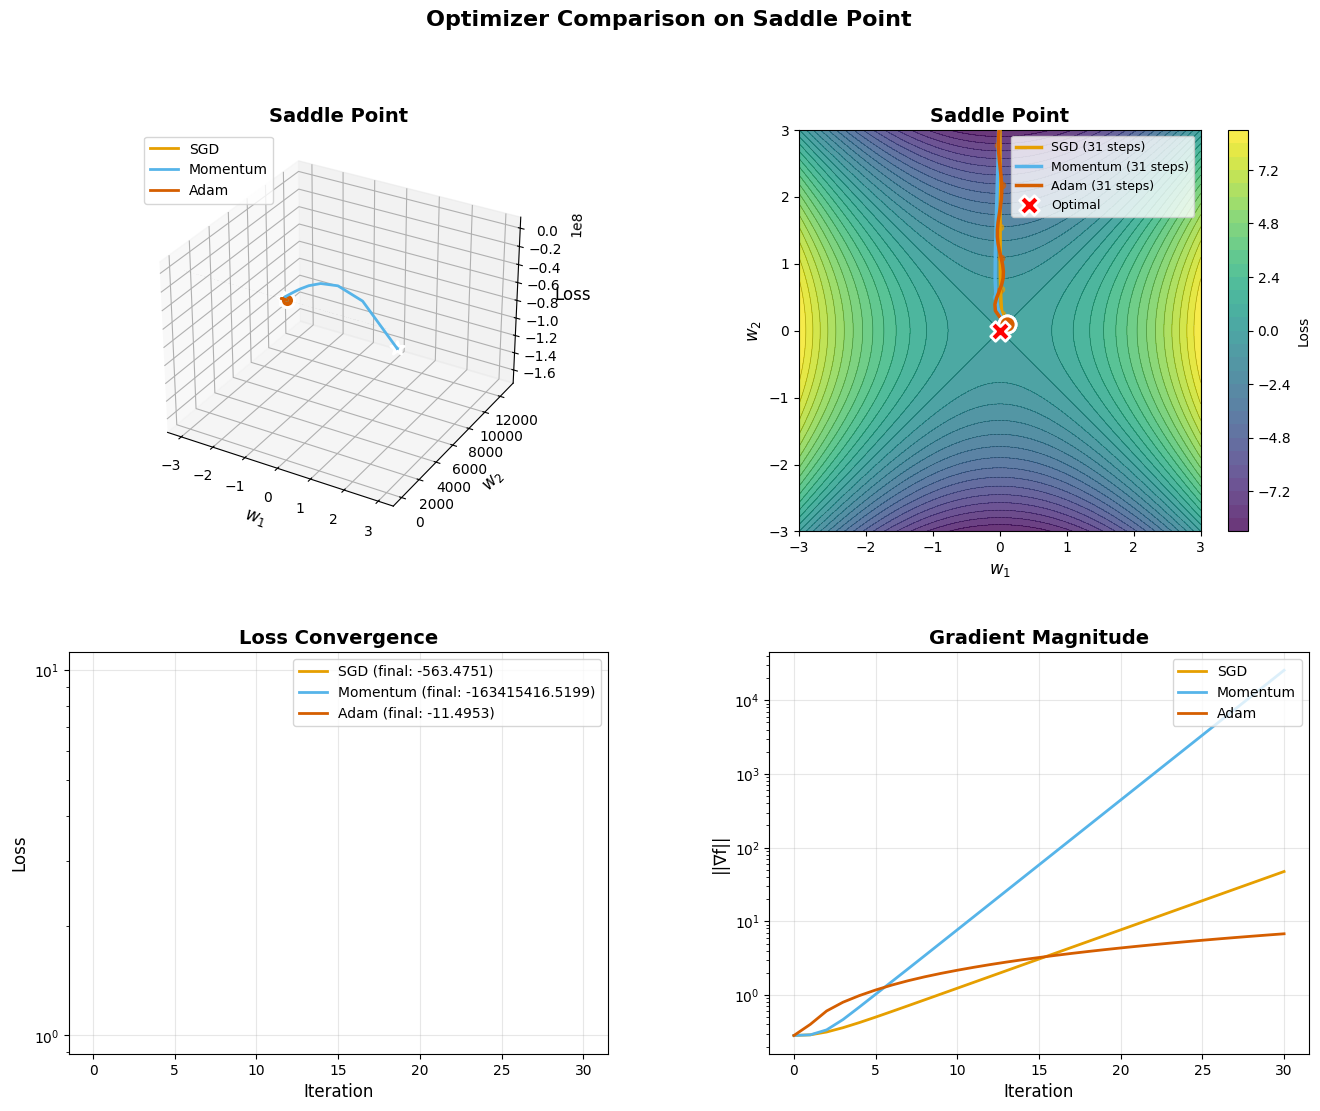


Optimizer       Steps    Final Loss   Final Position           
---------------------------------------------------------------
SGD             31       -563.475144  [0.0001, 23.7376]        
Momentum        31       -163415416.519872 [0.0044, 12783.4039]     
Adam            31       -11.495265   [0.0143, 3.3905]         


In [34]:
# Saddle point surface
surface = SaddlePoint()
initial = np.array([0.1, 0.1])  # Start near the saddle

print(f"Surface: {surface.name}")
print("Saddle point at origin: gradient is zero but it's not a minimum!")
print(f"Starting very close to saddle: {initial}")

optimizers = [
    SGD(learning_rate=0.1),
    Momentum(learning_rate=0.1, beta=0.9),
    Adam(learning_rate=0.1),
]

trajectories = []
for opt in optimizers:
    history = run_optimization(surface, opt, initial, num_steps=30)
    trajectories.append(history)

fig = create_comparison_figure(surface, trajectories)
plt.show()

print("\n" + create_optimizer_summary_table(trajectories))


---
## Part 4: Data-Driven Loss Surfaces

Now let's look at actual machine learning loss surfaces derived from data.

### 4.1 Logistic Regression on Different Datasets


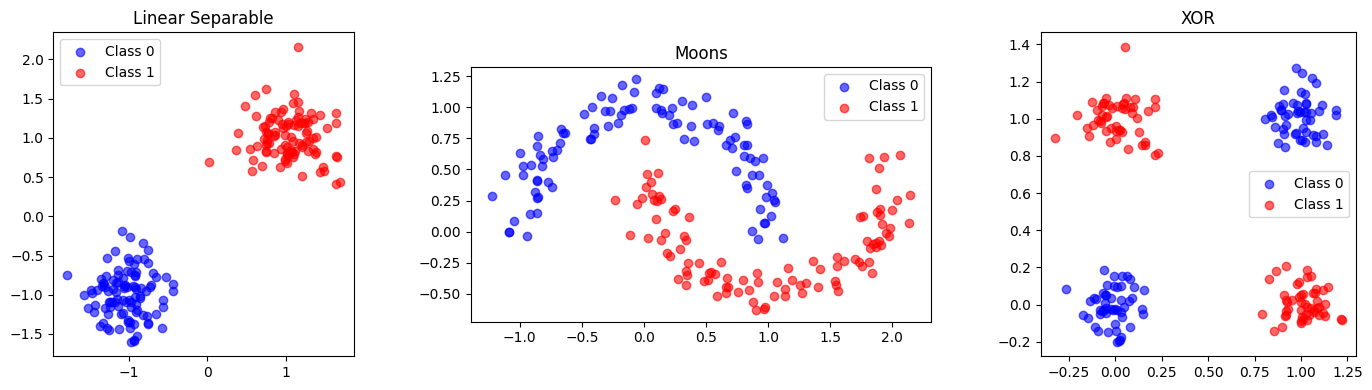

In [35]:
# Generate different datasets
datasets = [
    generate_linear_separable(n_samples=200, noise=0.3),
    generate_moons(n_samples=200, noise=0.1),
    generate_xor(n_samples=200, noise=0.1),
]

# Visualize datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, data in zip(axes, datasets):
    ax.scatter(data.X[data.y==0, 0], data.X[data.y==0, 1], c='blue', alpha=0.6, label='Class 0')
    ax.scatter(data.X[data.y==1, 0], data.X[data.y==1, 1], c='red', alpha=0.6, label='Class 1')
    ax.set_title(data.name)
    ax.legend()
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


Dataset: Linear Separable
Samples: 200
Optimal weights (approx): [2.0036654  1.96863293]


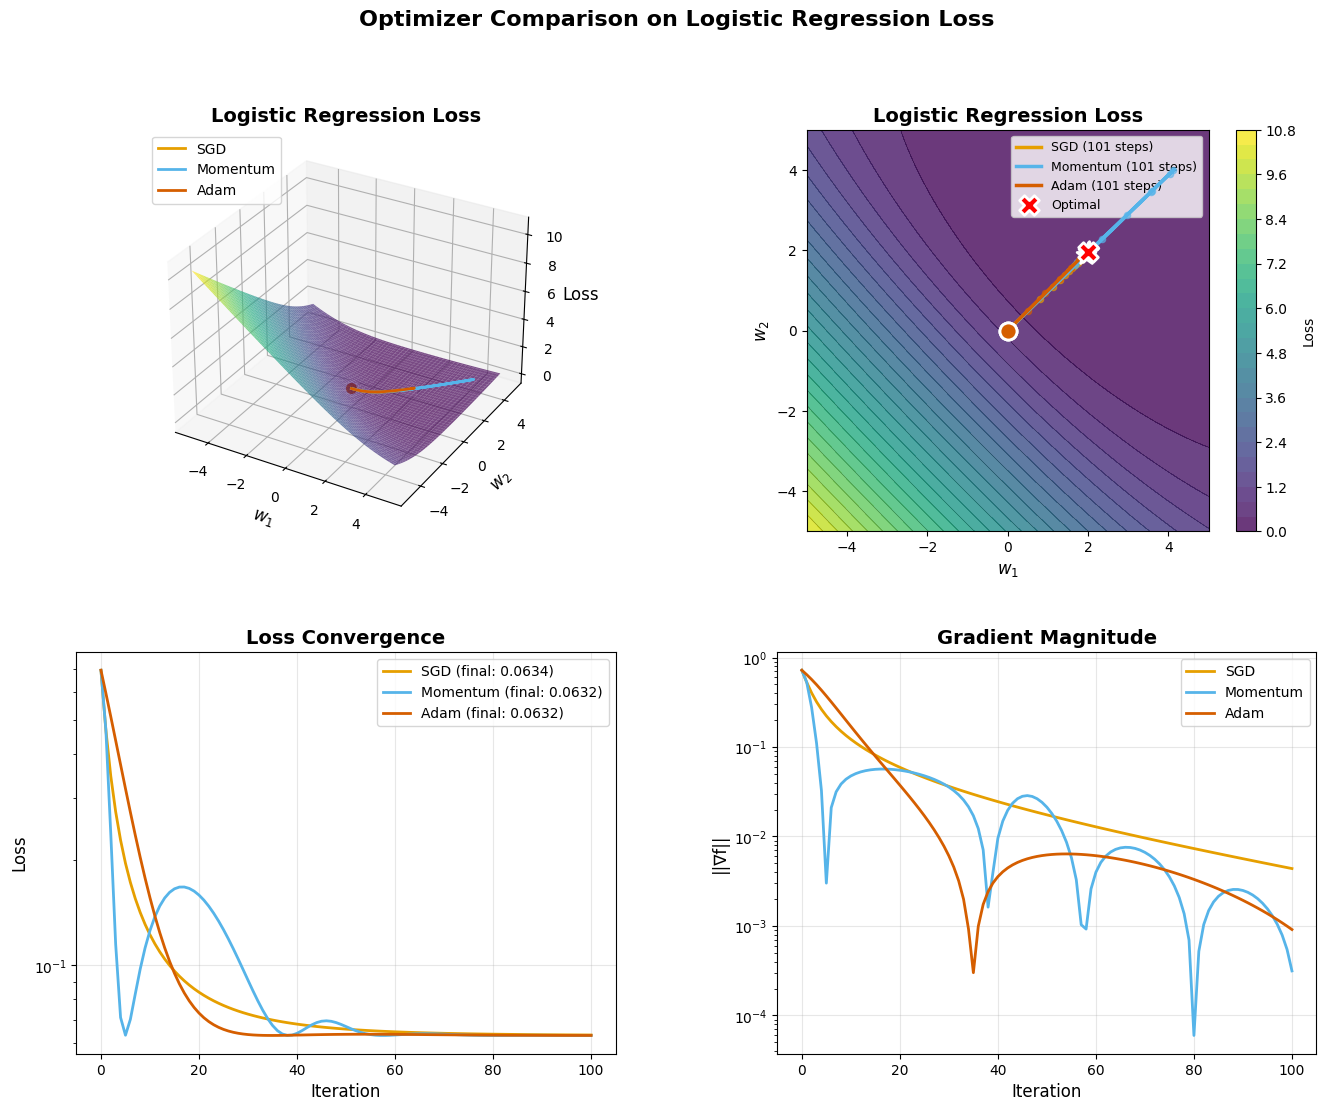


Optimizer       Steps    Final Loss   Final Position           
---------------------------------------------------------------
SGD             101      0.063393     [1.9477, 1.8932]         
Momentum        101      0.063194     [2.0001, 1.9624]         
Adam            101      0.063203     [2.0113, 1.9900]         


In [36]:
# Optimize logistic regression on the linearly separable dataset
data = generate_linear_separable(n_samples=200, noise=0.3)
surface = LogisticRegressionLoss(data.X, data.y, regularization=0.01)

print(f"Dataset: {data.name}")
print(f"Samples: {data.n_samples}")
print(f"Optimal weights (approx): {surface.get_optimal()}")

initial = np.array([0.0, 0.0])

optimizers = [
    SGD(learning_rate=0.5),
    Momentum(learning_rate=0.5, beta=0.9),
    Adam(learning_rate=0.1),
]

trajectories = []
for opt in optimizers:
    history = run_optimization(surface, opt, initial, num_steps=100)
    trajectories.append(history)

fig = create_comparison_figure(surface, trajectories)
plt.show()

print("\n" + create_optimizer_summary_table(trajectories))


---
## Part 5: Learning Rate Analysis

The learning rate is crucial. Let's see what happens with different values.


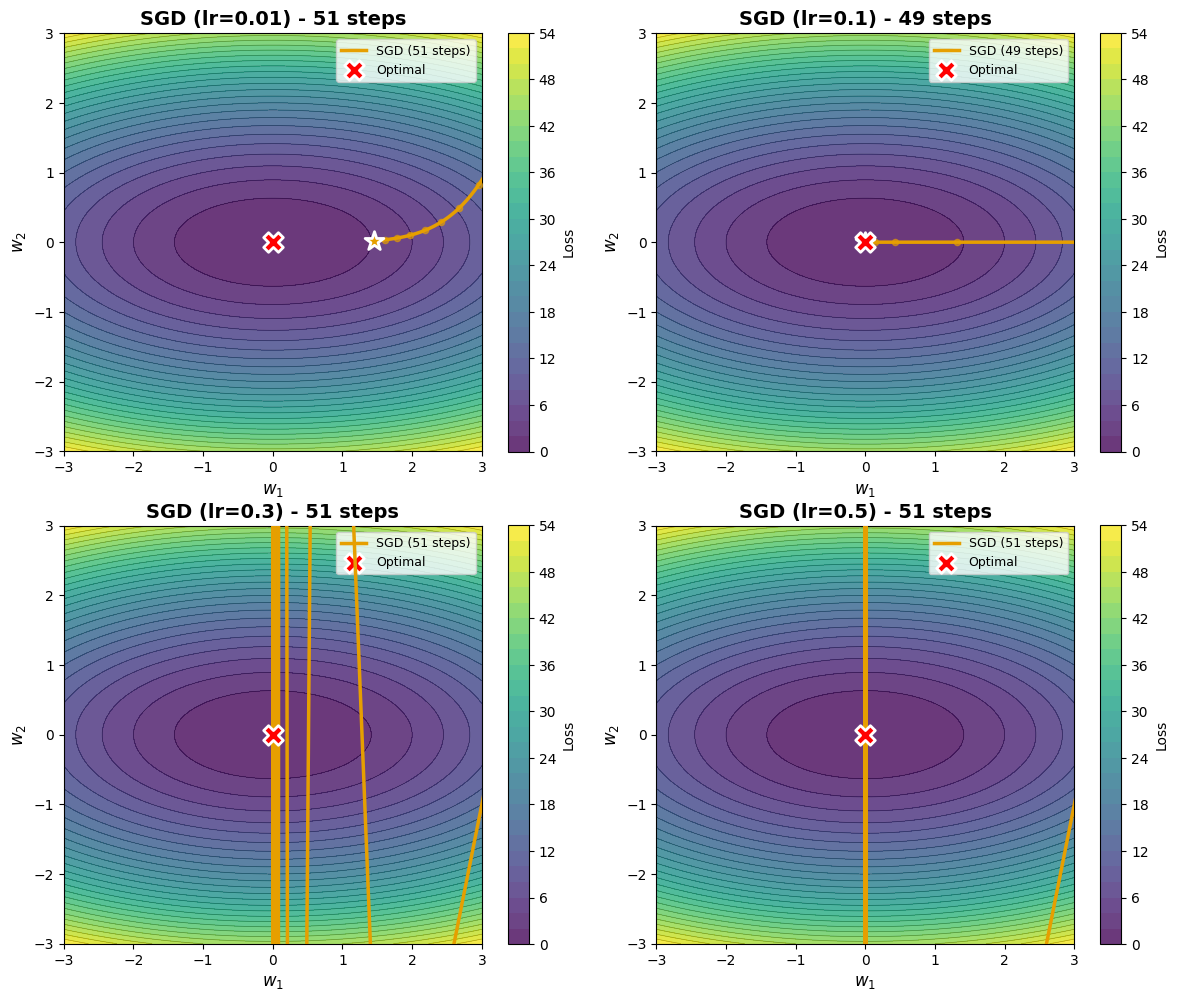


Observations:
• Too small (0.01): Slow convergence
• Just right (0.1-0.3): Fast convergence
• Too large (0.5): May oscillate or diverge


In [37]:
surface = QuadraticBowl(a=1.0, b=5.0)
initial = np.array([4.0, 4.0])

learning_rates = [0.01, 0.1, 0.3, 0.5]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, lr in enumerate(learning_rates):
    opt = SGD(learning_rate=lr)
    history = run_optimization(surface, opt, initial, num_steps=50)
    
    viz = SurfaceVisualizer(surface)
    viz.plot_contour(ax=axes[idx], trajectories=[history], 
                    title=f"SGD (lr={lr}) - {len(history.steps)} steps")

plt.tight_layout()
plt.show()

print("\nObservations:")
print("• Too small (0.01): Slow convergence")
print("• Just right (0.1-0.3): Fast convergence")
print("• Too large (0.5): May oscillate or diverge")


---
## Part 6: Interactive Exploration

Use the cells below to experiment with your own configurations!


Surface: Rosenbrock
Starting: [-1.  2.]
Optimal: [1. 1.]
Steps: 500


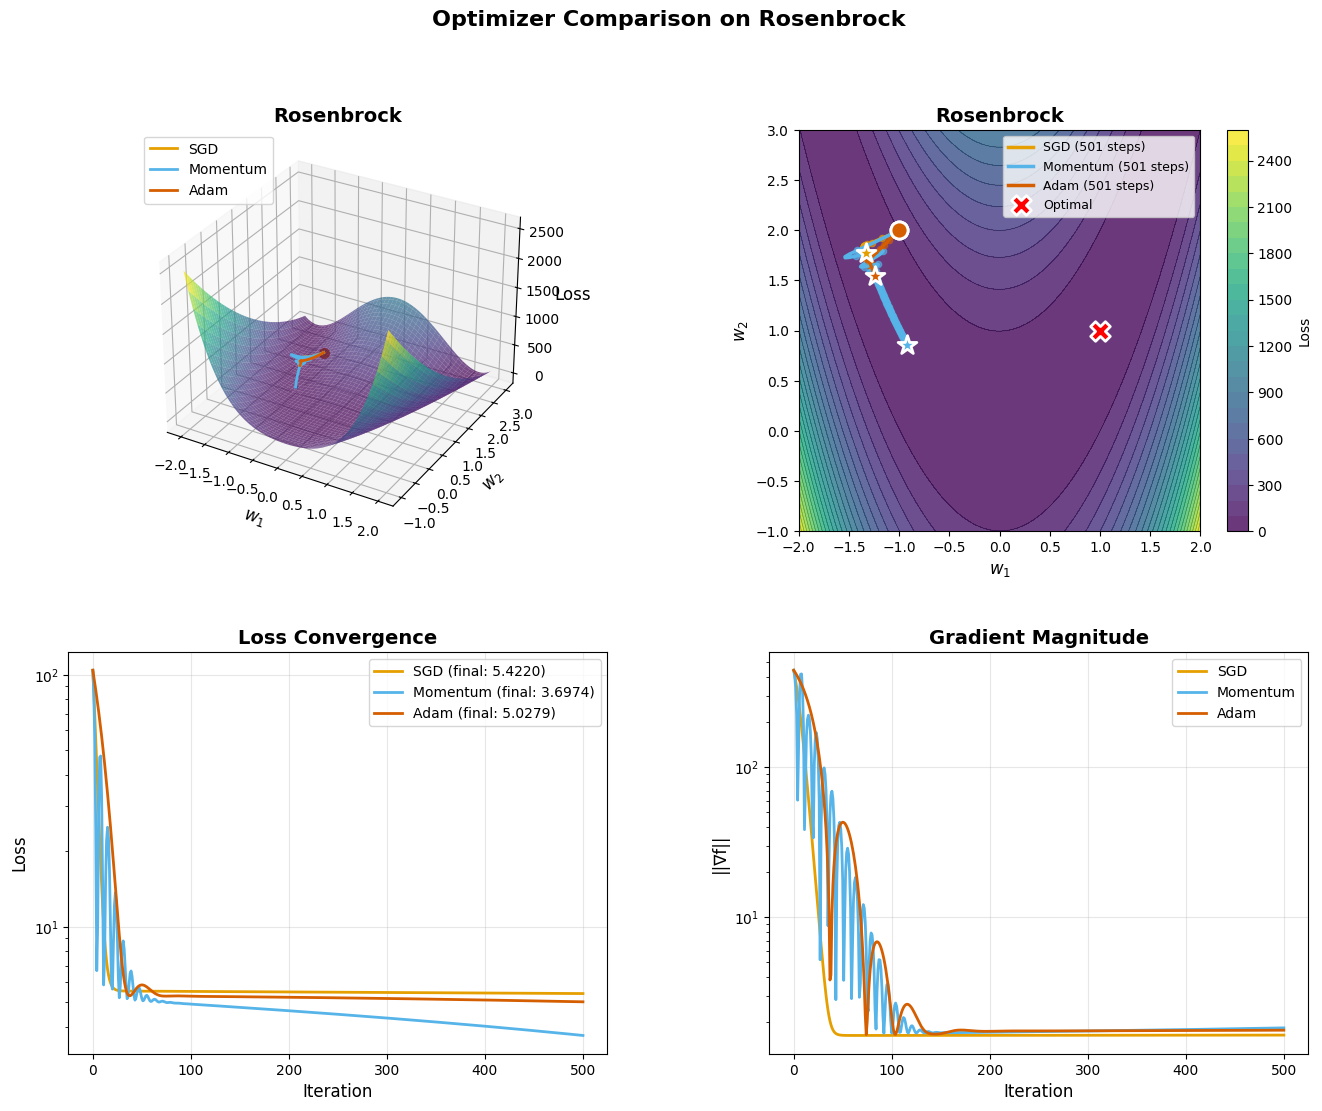


Optimizer       Steps    Final Loss   Final Position           
---------------------------------------------------------------
SGD             501      5.422004     [-1.3273, 1.7693]        
Momentum        501      3.697359     [-0.9212, 0.8566]        
Adam            501      5.027912     [-1.2413, 1.5475]        


In [38]:
# ============================================
# CUSTOMIZE YOUR EXPERIMENT HERE
# ============================================

# Choose a loss surface
# Options: QuadraticBowl(), Rosenbrock(), Rastrigin(), Ackley(), SixHumpCamel(), SaddlePoint()
surface = Rosenbrock()

# Set starting point
initial = np.array([-1.0, 2.0])

# Configure optimizers (add/remove as needed)
optimizers = [
    SGD(learning_rate=0.0001),
    Momentum(learning_rate=0.0001, beta=0.9),
    Adam(learning_rate=0.01),
]

# Number of optimization steps
num_steps = 500

# ============================================
# RUN EXPERIMENT
# ============================================

print(f"Surface: {surface.name}")
print(f"Starting: {initial}")
print(f"Optimal: {surface.get_optimal()}")
print(f"Steps: {num_steps}")

trajectories = []
for opt in optimizers:
    history = run_optimization(surface, opt, initial, num_steps=num_steps)
    trajectories.append(history)

fig = create_comparison_figure(surface, trajectories)
plt.show()

print("\n" + create_optimizer_summary_table(trajectories))


---
## Part 7: PCA Visualization for High-Dimensional Data

For higher-dimensional problems, we can use PCA to project the optimization trajectory into 2D.


Dataset: Dataset('High-Dim Classification (20D)', samples=500, features=20)

Projected to 2D
Explained variance: [0.22085527 0.19082633]
Total variance explained: 41.17%


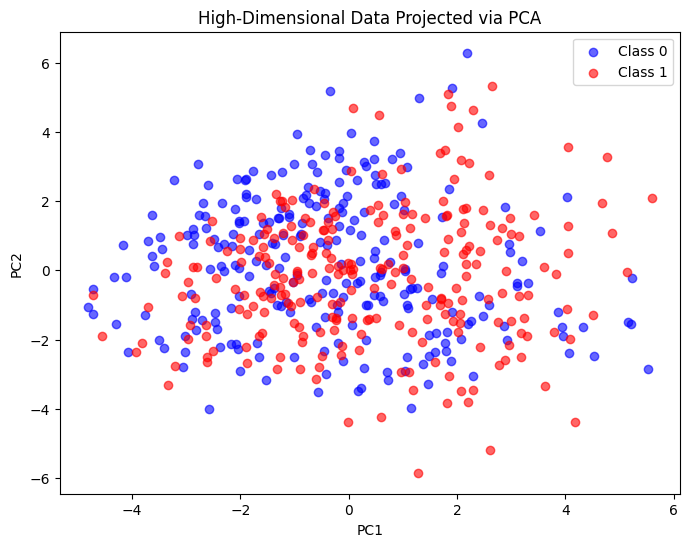

In [39]:
from datasets import generate_high_dim_classification

# Generate high-dimensional data
high_dim_data = generate_high_dim_classification(
    n_samples=500,
    n_features=20,
    n_informative=10,
    random_state=42
)

print(f"Dataset: {high_dim_data}")

# Apply PCA
projector = PCAProjector(n_components=2)
X_2d = projector.fit_transform(high_dim_data.X)

print(f"\nProjected to 2D")
print(f"Explained variance: {projector.explained_variance_ratio}")
print(f"Total variance explained: {sum(projector.explained_variance_ratio):.2%}")

# Visualize projected data
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[high_dim_data.y==0, 0], X_2d[high_dim_data.y==0, 1], 
           c='blue', alpha=0.6, label='Class 0')
plt.scatter(X_2d[high_dim_data.y==1, 0], X_2d[high_dim_data.y==1, 1], 
           c='red', alpha=0.6, label='Class 1')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('High-Dimensional Data Projected via PCA')
plt.legend()
plt.show()


---
## Summary

### Key Takeaways

1. **Convex surfaces**: All optimizers converge, but adaptive methods (Adam, RMSprop) handle ill-conditioning better.

2. **Local minima**: Momentum helps escape shallow local minima. Starting point matters!

3. **Saddle points**: Momentum-based methods escape saddles more easily than pure SGD.

4. **Learning rate**: Critical hyperparameter. Too small = slow, too large = unstable.

5. **Adaptive methods**: Adam combines the benefits of momentum and per-parameter learning rates.

### Optimizer Recommendations

| Scenario | Recommended Optimizer |
|----------|----------------------|
| General deep learning | Adam |
| Convex problems | SGD with momentum |
| Sparse gradients | AdaGrad or Adam |
| Fine-tuning | SGD with small lr |
| Unknown landscape | Adam (robust default) |
